In [ ]:
!pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 9.2 MB/s eta 0:00:00


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pprint

cid = '0f4c62f01e2341348afb89fb5beb4784'
secret = 'cc0d1a43439b4fe585a10e1d06a68a4e'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor

In [ ]:
df = pd.read_csv("audio_features.csv")
print("There are {} observations for {} predictors.".format(df.shape[0],df.shape[1]))
df.head()

There are 844 observations for 19 predictors.


,track_name,artist_name,artist_popularity,album_name,track_popularity,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,release_date
0,"Be Who You Are (Real Magic) (feat. JID, NewJea...",Jon Batiste,80,Be Who You Are (Real Magic),67,0.657,0.875,-4.206,1,2,0.0890,0.0328,0.000000,0.2670,0.745,143.884,4,189714,2023-05-31
1,Zero,NewJeans,80,Zero,78,0.705,0.653,-7.407,0,1,0.1700,0.3100,0.000015,0.1220,0.578,171.932,4,154194,2023-04-03
2,OMG,NewJeans,80,NewJeans 'OMG',92,0.804,0.771,-4.067,0,9,0.0433,0.3570,0.000003,0.1080,0.739,126.956,4,212253,2023-01-02
3,Ditto,NewJeans,80,NewJeans 'OMG',70,0.814,0.641,-5.957,0,6,0.1110,0.0270,0.000000,0.0993,0.183,133.854,4,185507,2023-01-02
4,Ditto,NewJeans,80,Ditto,89,0.814,0.641,-5.957,0,6,0.1110,0.0270,0.000000,0.0993,0.183,133.854,4,185507,2022-12-19


Data Analyze

<Axes: xlabel='track_popularity'>

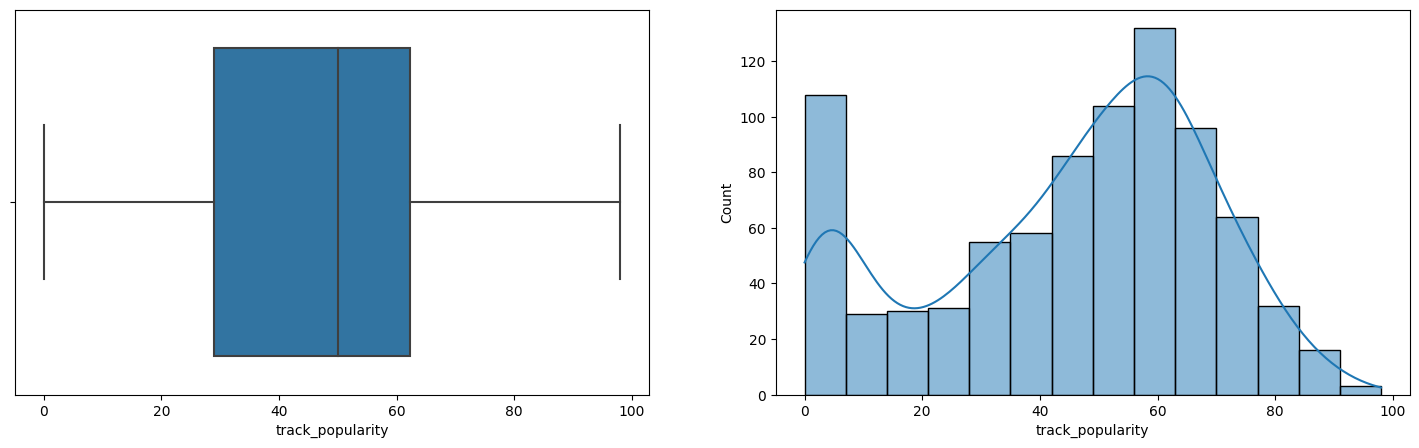

In [ ]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(x = 'track_popularity', data = df, kde = True)
plt.subplot(1,2,1)
sns.boxplot(x = 'track_popularity', data = df)
# track_popularity가 20 미만인게 유독 높네...

In [ ]:
# 인기 아티스트
top_artists = df[["artist_name", "artist_popularity"]].sort_values('artist_popularity',ascending=False)
top_artists = top_artists.artist_name.unique()[:5]
top_artists

array(['BTS', 'BLACKPINK', 'ROSÉ', 'JENNIE', 'Jimin'], dtype=object)

In [ ]:
# 아티스트 인기와 인기곡 간의 상관관계
correlation = df["artist_popularity"].corr(df["track_popularity"])
print("Correlation coefficient:", correlation)
# 생각보다 높지 않음 (수록곡 포함되서 그런가..?)

Correlation coefficient: 0.3854436271130039


<Axes: >

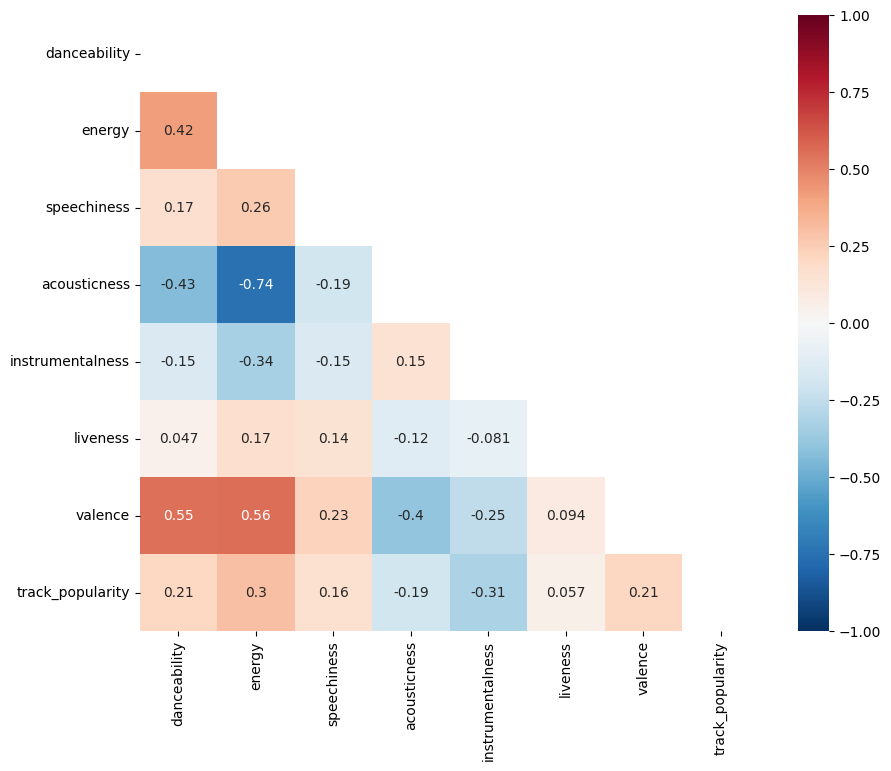

In [ ]:
# 분위기(mood)와 곡 인기도
columns_mood = ["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence","track_popularity"]

mask = np.triu(np.ones_like(df[columns_mood].corr(), dtype=bool))

plt.figure(figsize = (10,8))
sns.heatmap(df[columns_mood].corr(), mask=mask, annot = True, vmin= -1.0, vmax= 1.0, center = 0, cmap = 'RdBu_r')

<Axes: >

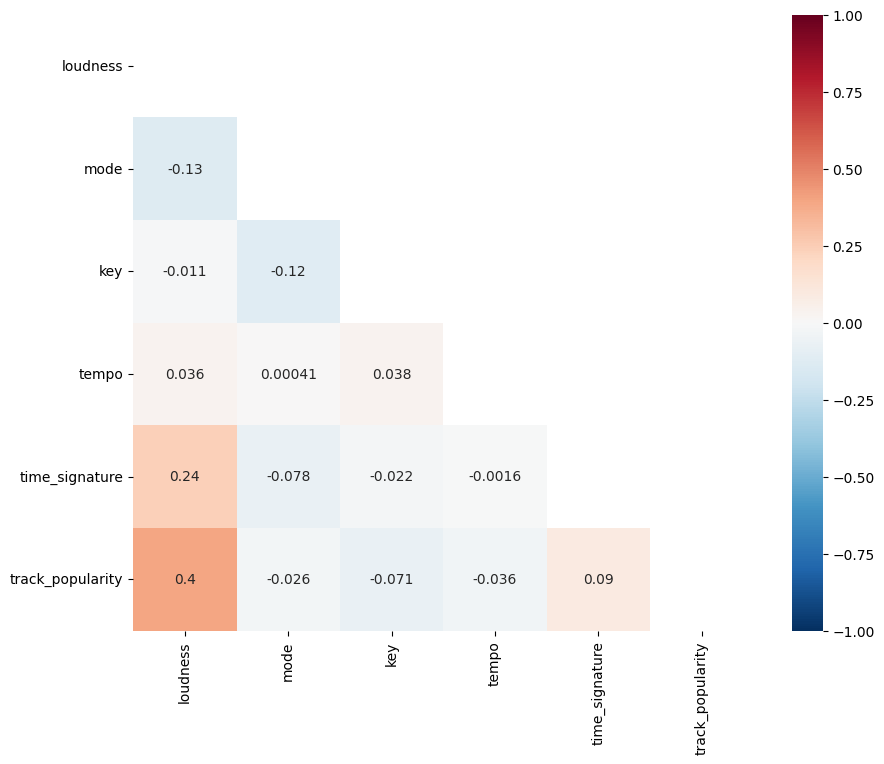

In [ ]:
# 음향 특성(accoustic)과 곡 인기도
columns_acoustic = ["loudness", "mode", "key", "tempo", "time_signature","track_popularity"]

mask = np.triu(np.ones_like(df[columns_acoustic].corr(), dtype=bool))

plt.figure(figsize = (10,8))
sns.heatmap(df[columns_acoustic].corr(), mask=mask, annot = True, vmin= -1.0, vmax= 1.0, center = 0, cmap = 'RdBu_r')

<Axes: xlabel='duration_ms', ylabel='track_popularity'>

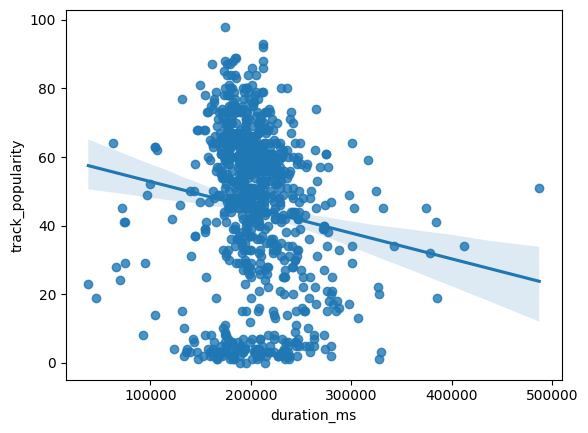

In [ ]:
# 노래길이와 인기곡
sns.regplot(x=df["duration_ms"], y=df["track_popularity"])

In [ ]:
by_track_pop = pd.DataFrame(df.sort_values(by=['track_popularity'], ascending=False))
by_track_pop[:100]

,track_name,artist_name,artist_popularity,album_name,track_popularity,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,release_date
542,Cupid - Twin Ver.,FIFTY FIFTY,81,The Beginning: Cupid,98,0.783,0.592,-8.332,0,11,0.0331,0.4350,0.000004,0.3470,0.726,120.018,4,174253,2023-02-24
500,Like Crazy,Jimin,84,FACE,93,0.629,0.733,-5.445,1,7,0.0419,0.0025,0.000000,0.3570,0.362,120.001,4,212241,2023-03-24
2,OMG,NewJeans,80,NewJeans 'OMG',92,0.804,0.771,-4.067,0,9,0.0433,0.3570,0.000003,0.1080,0.739,126.956,4,212253,2023-01-02
28,I AM,IVE,78,I've IVE,89,0.683,0.875,-4.866,0,4,0.0549,0.0115,0.000000,0.0840,0.384,122.002,4,183853,2023-04-10
4,Ditto,NewJeans,80,Ditto,89,0.814,0.641,-5.957,0,6,0.1110,0.0270,0.000000,0.0993,0.183,133.854,4,185507,2022-12-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,Blue Blood,IVE,78,I've IVE,71,0.711,0.709,-5.923,0,1,0.0374,0.0041,0.000099,0.0843,0.695,98.949,4,167547,2023-04-10
375,Hello Future,NCT DREAM,73,Hello Future - The 1st Album Repackage,71,0.545,0.803,-2.283,1,1,0.0526,0.0261,0.000000,0.1140,0.500,170.006,4,220920,2021-06-28
80,Fire in the belly,LE SSERAFIM,79,UNFORGIVEN,71,0.716,0.779,-3.735,0,9,0.0589,0.0106,0.000000,0.0266,0.442,119.932,4,198233,2023-05-01
388,Hot Sauce,NCT DREAM,73,Hot Sauce - The 1st Album,71,0.769,0.926,-1.627,1,6,0.0788,0.0127,0.000000,0.2850,0.551,100.034,4,195813,2021-05-10


In [ ]:
# 인기곡 평균과 전체 평균
feat_cols = ["danceability",	"energy", "speechiness",	"acousticness",	"instrumentalness",	"liveness",	"valence"]
top_100_feat = pd.DataFrame(columns=feat_cols)
for i, track in by_track_pop[:100].iterrows():
    features = df[df['track_name'] == track['track_name']]
    top_100_feat = top_100_feat.append(features, ignore_index=True)
top_100_feat = top_100_feat[feat_cols]

from sklearn import preprocessing
mean_vals = pd.DataFrame(columns=feat_cols)
mean_vals = mean_vals.append(top_100_feat.mean(), ignore_index=True)
mean_vals = mean_vals.append(df[feat_cols].mean(), ignore_index=True)
print(mean_vals)

# 그래프 그리기

import plotly.graph_objects as go
import plotly.offline as pyo
fig = go.Figure(
    data=[
        go.Scatterpolar(r=mean_vals.iloc[0], theta=feat_cols, fill='toself', name='Top 100'),
        go.Scatterpolar(r=mean_vals.iloc[1], theta=feat_cols, fill='toself', name='All'),
    ],
    layout=go.Layout(
        title=go.layout.Title(text='Feature comparison'),
        polar={'radialaxis': {'visible': True}},
        showlegend=True
    )
)

fig.show()

<ipython-input-15-622b08715edd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_feat = top_100_feat.append(features, ignore_index=True)
<ipython-input-15-622b08715edd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_feat = top_100_feat.append(features, ignore_index=True)
<ipython-input-15-622b08715edd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_feat = top_100_feat.append(features, ignore_index=True)
<ipython-input-15-622b08715edd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_100_feat = top_100_feat.append(features, ignore_index=True)
<ipython-input-15-622b08715edd>:6: FutureWarning: The frame.appe

   danceability    energy  speechiness  acousticness  instrumentalness  \
0      0.707435  0.749040     0.091523      0.144563          0.006778   
1      0.649860  0.681893     0.080726      0.241470          0.061566   

   liveness   valence  
0  0.183933  0.562298  
1  0.169075  0.518878  


Prediction of Model

In [ ]:
# data load
def load_data():
    # Read data
    df = pd.read_csv("audio_features.csv",index_col=0)
    df = df[[ "artist_name", "danceability", "energy", "speechiness", "acousticness", "liveness", "mode", "tempo", "time_signature", "track_popularity"]]

    # Preprocessing the data
    # artist와 track간의 one-hot incoding -> xtest에서 사용
    dummies = pd.get_dummies(df["artist_name"], drop_first= True)
    df = pd.concat([df,dummies],axis=1)
    df.drop(columns=["artist_name"], inplace=True)

    X = df.copy()
    y = X.pop("track_popularity")
    print(X)
    xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state = 1,test_size=0.3, shuffle=True)

    return xtrain,xtest,ytrain,ytest



In [ ]:
df

,track_name,artist_name,artist_popularity,album_name,track_popularity,danceability,energy,loudness,mode,key,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,release_date
0,"Be Who You Are (Real Magic) (feat. JID, NewJea...",Jon Batiste,80,Be Who You Are (Real Magic),67,0.657,0.875,-4.206,1,2,0.0890,0.03280,0.000000,0.2670,0.745,143.884,4,189714,2023-05-31
1,Zero,NewJeans,80,Zero,78,0.705,0.653,-7.407,0,1,0.1700,0.31000,0.000015,0.1220,0.578,171.932,4,154194,2023-04-03
2,OMG,NewJeans,80,NewJeans 'OMG',92,0.804,0.771,-4.067,0,9,0.0433,0.35700,0.000003,0.1080,0.739,126.956,4,212253,2023-01-02
3,Ditto,NewJeans,80,NewJeans 'OMG',70,0.814,0.641,-5.957,0,6,0.1110,0.02700,0.000000,0.0993,0.183,133.854,4,185507,2023-01-02
4,Ditto,NewJeans,80,Ditto,89,0.814,0.641,-5.957,0,6,0.1110,0.02700,0.000000,0.0993,0.183,133.854,4,185507,2022-12-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,Charmer,Stray Kids,83,ODDINARY,74,0.786,0.762,-2.508,1,1,0.0519,0.05240,0.000010,0.0971,0.731,90.963,4,188573,2022-03-18
840,FREEZE,Stray Kids,83,ODDINARY,66,0.643,0.868,-2.715,0,11,0.1460,0.00674,0.000000,0.0691,0.657,159.874,4,178387,2022-03-18
841,Lonely St.,Stray Kids,83,ODDINARY,64,0.686,0.825,-3.192,1,7,0.0582,0.24800,0.000000,0.0761,0.603,90.053,4,164853,2022-03-18
842,"Waiting For Us (Bang Chan, Lee Know, Seungmin,...",Stray Kids,83,ODDINARY,63,0.419,0.595,-3.925,1,3,0.0278,0.10200,0.000000,0.0895,0.347,87.822,4,219507,2022-03-18


In [ ]:
xtrain,xtest,ytrain,ytest = load_data()

                                                    danceability  energy  \
track_name                                                                 
Be Who You Are (Real Magic) (feat. JID, NewJean...         0.657   0.875   
Zero                                                       0.705   0.653   
OMG                                                        0.804   0.771   
Ditto                                                      0.814   0.641   
Ditto                                                      0.814   0.641   
...                                                          ...     ...   
Charmer                                                    0.786   0.762   
FREEZE                                                     0.643   0.868   
Lonely St.                                                 0.686   0.825   
Waiting For Us (Bang Chan, Lee Know, Seungmin, ...         0.419   0.595   
Muddy Water (Changbin, Hyunjin, HAN, Felix)                0.760   0.871   

           

In [ ]:
# define best model
# 스태킹 앙상블(Stacking Ensemble)을 사용하여 회귀 모델을 조합하는 함수
def stackblend_reg(x_train,y_train,x_test,models,code,N=20,final_layer=LinearRegression()):
    # 데이터셋 분할
    def get_dataset(x_train,y_train,N=5) :
        merge = pd.concat([x_train,y_train],axis=1)
        merge = merge.sample(frac=1, random_state=1).reset_index(drop=True)
        y_train = merge.iloc[:,(merge.shape[1]-1):(merge.shape[1])]
        x_train = merge.iloc[:,0:(merge.shape[1]-1)]

        z = int(len(x_train)/N)
        start = [0]
        stop = []
        for i in range(1,N):
            start.append(z*i)
            stop.append(z*i)
        stop.append(len(x_train))

        c = list()
        train_data = list()
        test_data = list()
        y_data = list()
        for i in range(0,N):
            c=list(range(start[i],stop[i]))
            train_data.append(x_train.iloc[[k for k in range(0,len(x_train)) if k not in c],:])
            y_data.append(y_train.iloc[[k for k in range(0,len(y_train)) if k not in c],:])
            test_data.append(x_train.iloc[c,:])

        return(train_data,y_data,test_data,y_train)

    datasets = get_dataset(x_train,y_train,N)
    train_data = datasets[0]
    y_data = datasets[1]
    test_data = datasets[2]
    final_y =  datasets[3]

    # 스태킹 앙상블 수행하는 함수
    def stack(x_train, y_train , x_test , models=models,code=code):

        # 2차원 리스트를 1차원 리스트로 변환하는 함수
        def flatten_list(_2d_list):
            flat_list = []
            for element in _2d_list:
                if type(element) is list:
                    for item in element:
                        flat_list.append(item)
                else:
                    flat_list.append(element)
            return flat_list

        result = list()
        for i in list(range(len(models))):
            reg = models[i]
            reg.fit(x_train,y_train)
            test_pred = flatten_list(reg.predict(x_test).tolist())
            result.append(test_pred)

        result_df = pd.DataFrame()
        for i in list(range(len(code))):
            result_df[code[i]] = result[i]
        return result_df

    # 스태킹 앙상블을 통해 생성된 데이터 프레임을 저장하는 변수
    # -> 여러 번의 데이터셋 분할과 스태킹 앙상블 과정을 거치면서 생성된 데이터 프레임들을 이어붙여 최종 데이터 프레임을 구성
    final_df = pd.DataFrame(columns = code)

    for i in range(0,len(train_data)):
        current_df = stack(train_data[i],y_data[i],test_data[i],models,code)
        final_df = pd.concat([final_df,current_df])

    # 훈련 데이터로 스태킹 앙상블을 수행하여 최종 예측을 위한 회귀 모델 학습 후 테스트 데이터에 대한 예측값
    final_test = stack(x_train,y_train,x_test,models,code)

    # 최종 예측을 위한 회귀 모델 학습 및 예측
    reg2 = final_layer
    reg2.fit(final_df,final_y)
    test_pred = reg2.predict(final_test)

    return test_pred

In [ ]:
# 평가할 모델들을 딕셔너리 형태로 정의
models = {}

models["KNeighborsRegressor"]={"model":KNeighborsRegressor(n_neighbors=50)}
models["CatBoostRegressor"]={"model":CatBoostRegressor(logging_level ='Silent',iterations=100)}
models["LinearRegression"]={"model":LinearRegression()}
models["XGBRegressor"]={"model":XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1)}

In [ ]:
# 데이터셋의 성능을 평가하는 함수
def score_dataset(X, y, model):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes

    scores = cross_validate(model, X, y, cv=5, scoring=["r2","neg_mean_absolute_error"])
    score_r2 = scores["test_r2"].mean()
    score_mae = -1*scores["test_neg_mean_absolute_error"].mean()

    return score_r2, score_mae

In [ ]:
 # 모든 모델의 성능을 평가하고 결과를 출력하는 함수
 def get_scores(models,xtrain,ytrain):
    for name,model in models.items():
        model["model"].fit(xtrain,ytrain)

        score_r2, score_mae = score_dataset(xtrain, ytrain, model=model["model"])
        print("--- "+name+" ---")
        print("Score r2: {}".format(score_r2))
        print("Score MAE: {}".format(score_mae))
        print("\n")

In [ ]:
get_scores(models,xtrain,ytrain)

--- KNeighborsRegressor ---
Score r2: -0.005574009876589003
Score MAE: 19.750677966101694


--- CatBoostRegressor ---
Score r2: 0.472393079761947
Score MAE: 13.494469097957104


--- LinearRegression ---
Score r2: -8.678646875622811e+19
Score MAE: 16565289242.592686


--- XGBRegressor ---
Score r2: 0.494130863072491
Score MAE: 12.478476555468673




In [ ]:
# 모델들의 성능 평가 및 스태킹 앙상블을 사용하여 최종 예측 수행
stack_pred = stackblend_reg(xtrain,ytrain,xtest,
                            models = [XGBRegressor(n_jobs=5,learning_rate=0.01,max_depth=10,random_state=1),
                                    KNeighborsRegressor(n_neighbors=50),
                                     CatBoostRegressor(logging_level ='Silent',iterations=1000,random_state=1)],
                            code = ['xgb_reg','knn_reg','cat_reg'],N=10,
                            final_layer=KNeighborsRegressor(n_neighbors=50))

In [ ]:
print("========Prediction======")
for i in range(len(ytest)):
  print(ytest.index[i]) # index -> track_name
  print("real : ", ytest[i])
  print("pred : ", stack_pred[i])
  print("------------------------")

========Prediction======
Outro : Encore
real :  34
pred :  [30.26]
------------------------
THE MIRACLE (Inst.)
real :  19
pred :  [32.8]
------------------------
BETTER
real :  58
pred :  [59.5]
------------------------
MIRAGE
real :  25
pred :  [55.18]
------------------------
LAST WALTZ
real :  61
pred :  [59.68]
------------------------
Dream about You - Instrumental
real :  19
pred :  [31.92]
------------------------
Na zawsze i na wieczność
real :  4
pred :  [33.56]
------------------------
TIMELESS (Inst.)
real :  8
pred :  [33.44]
------------------------
WHAT I WANT
real :  50
pred :  [44.72]
------------------------
Do U Want Me Baby?
real :  6
pred :  [26.16]
------------------------
Hurt
real :  78
pred :  [66.]
------------------------
CIRCUS (Korean Ver.)
real :  60
pred :  [65.18]
------------------------
Fanfare
real :  57
pred :  [60.8]
------------------------
Lost Me
real :  64
pred :  [63.94]
------------------------
Like Crazy (UK Garage Remix)
real :  71
pred :  [

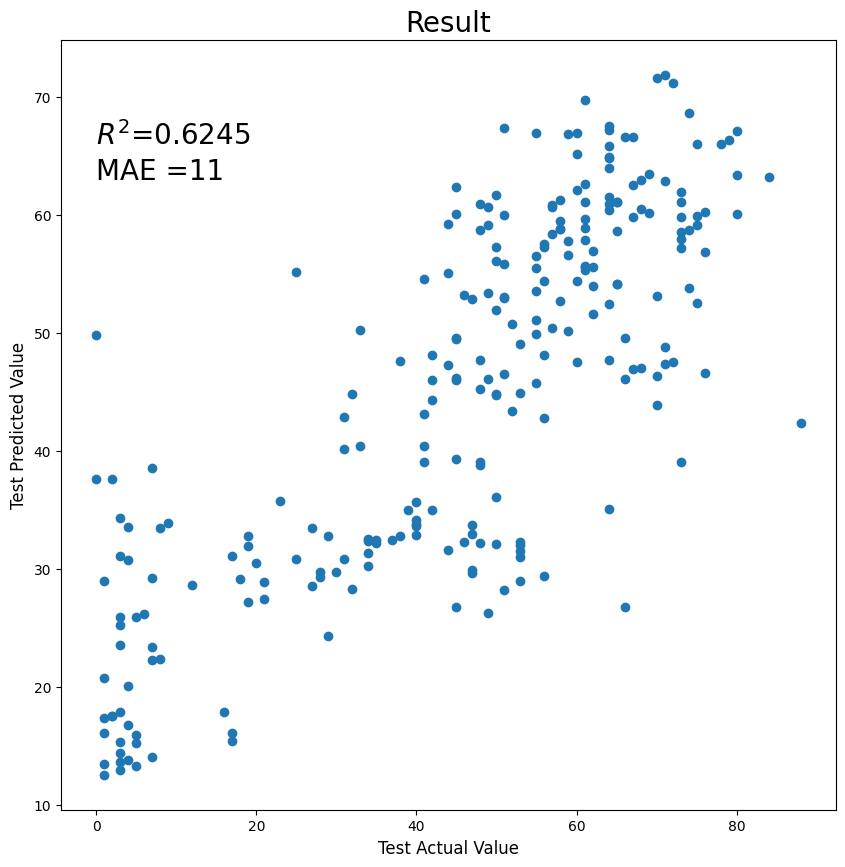

In [ ]:
score_r2 = r2_score(ytest, stack_pred)
score_mae = mean_absolute_error(ytest, stack_pred)
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title("Result",fontsize=20)
ax.set_ylabel('Test Predicted Value',fontsize=12)
ax.set_xlabel('Test Actual Value',fontsize=12)
ax.scatter(ytest,stack_pred)

score_r2 = r2_score(ytest, stack_pred)
score_mae = mean_absolute_error(ytest, stack_pred)
plt.text(0,66,'$ R^{2} $=' + str(round(score_r2, 4)),fontsize=20)
plt.text(0,63,'MAE =' + str(round(score_mae)),fontsize=20)
plt.show()

올해의 노래상 예측

In [ ]:
# data load
def load_data2():
    # Read data
    df = pd.read_csv("audio_features.csv",index_col=0)
    df = df[[ "artist_name", "danceability", "energy", "speechiness", "acousticness", "liveness", "mode", "tempo", "time_signature", "track_popularity"]]

    # Preprocessing the data
    # artist와 track간의 one-hot incoding -> xtest에서 사용
    dummies = pd.get_dummies(df["artist_name"], drop_first= True)
    df = pd.concat([df,dummies],axis=1)
    df.drop(columns=["artist_name"], inplace=True)

    X = df.copy()
    y = X.pop("track_popularity")
    #print(X)
    #xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state = 1,test_size=0.3, shuffle=True)

    # 음원 차트 순위 곡 랜덤 20개
    specific_indices = ["Hype Boy", "Ditto", "Spicy", "I AM", "Kitsch", "Queencard", "Nxde", "UNFORGIVEN (feat. Nile Rodgers)", "Cupid",
                        "FLOWER", "Event Horizon", "My Ultimate First Love", "Grain of Sand", "Heaven(2023)", "A Shining Day", "Shut Down", "CHRISTIAN",
                        "Dynamite", "S-Class", "Lonely Night"]
    xtest_specific = X.loc[specific_indices]
    ytest_specific = y.loc[specific_indices]

    return X, y, xtest_specific, ytest_specific


In [ ]:
x_train, y_train, x_test, y_test = load_data2()

In [ ]:
track_pop_pred = stackblend_reg(x_train,y_train,x_test,
                            models = [XGBRegressor(n_jobs=5,learning_rate=0.01,max_depth=10,random_state=1),
                                    KNeighborsRegressor(n_neighbors=50),
                                     CatBoostRegressor(logging_level ='Silent',iterations=1000,random_state=1)],
                            code = ['xgb_reg','knn_reg','cat_reg'],N=10,
                            final_layer=KNeighborsRegressor(n_neighbors=50))

In [ ]:
# 데이터와 인덱스를 함께 처리하는 DataFrame 생성
pred_df = pd.DataFrame(track_pop_pred, index=y_test.index, columns=['pred'])
df_sorted = pred_df.sort_values(by='pred', ascending=False)
df_sorted

,pred
track_name,
Hype Boy,71.80
Ditto,71.02
Ditto,71.02
Kitsch,70.32
Kitsch,70.32
UNFORGIVEN (feat. Nile Rodgers),69.98
S-Class,68.84
FLOWER,68.62
Spicy,68.50
